# Loading the Data and required libraries

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.model_selection import train_test_split

import string
import nltk
from tqdm import tqdm
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_hub as hub
import tensorflow as tf
from keras.models import Model
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, glue_convert_examples_to_features
from transformers import TFBertForSequenceClassification, BertTokenizer

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_hub as hub
import tensorflow as tf
from keras.models import Model
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, glue_convert_examples_to_features
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

In [5]:
drive.mount('/content/drive')
DIR = "drive/My Drive/mimic3 data/"

Mounted at /content/drive


In [6]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [8]:
def clean_text(texts):
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [9]:
adm_notes = adm_notes.dropna(subset=['TEXT'])

adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

# Model
## Words, Train and Test

Repartition data

In [11]:
df_train, df_test = train_test_split(adm_notes, test_size=0.3)

Subsample non-readmitted patients to match size of readmitted ones

In [12]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [13]:
df_test, df_val = train_test_split(df_test, test_size=0.5)

df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)
df_val = df_val.sample(n = len(df_val)).reset_index(drop = True)

# Recurrent Neural Network
## BERT

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
pad_token=0
pad_token_segment_id=0
max_length=512

def convert_to_input(texts):
  input_ids, attention_masks, token_type_ids = [], [], []

  for text in tqdm(texts, position=0, leave=True):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, truncation=True, return_token_type_ids=True)

    i, t = inputs["input_ids"], inputs["token_type_ids"]
    m = [1] * len(i)

    padding_length = max_length - len(i)

    i = i + ([pad_token] * padding_length)
    m = m + ([0] * padding_length)
    t = t + ([pad_token_segment_id] * padding_length)

    input_ids.append(i)
    attention_masks.append(m)
    token_type_ids.append(t)

  return [np.asarray(input_ids),
            np.asarray(attention_masks),
            np.asarray(token_type_ids)]

X_train_input = convert_to_input(df_train['TEXT'])
X_test_input = convert_to_input(df_test['TEXT'])
X_val_input = convert_to_input(df_val['TEXT'])

100%|██████████| 6582/6582 [04:00<00:00, 27.33it/s]


In [16]:
def to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y

train_data = (X_train_input[0], X_train_input[1], X_train_input[2], df_train['READM_WITHIN_30'])
test_data = (X_test_input[0], X_test_input[1], X_test_input[2], df_test['READM_WITHIN_30'])
val_data = (X_val_input[0], X_val_input[1], X_val_input[2], df_val['READM_WITHIN_30'])

train_ds = tf.data.Dataset.from_tensor_slices(train_data).map(to_features).shuffle(len(df_train['READM_WITHIN_30'])).batch(10)
test_ds = tf.data.Dataset.from_tensor_slices(test_data).map(to_features).batch(10)
val_ds = tf.data.Dataset.from_tensor_slices(val_data).map(to_features).batch(10)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3
415/415 [==============================] - 862s 2s/step - loss: 0.6968 - accuracy: 0.5048 - val_loss: 0.6672 - val_accuracy: 0.8943
Epoch 2/3
415/415 [==============================] - 750s 2s/step - loss: 0.6814 - accuracy: 0.5649 - val_loss: 0.7449 - val_accuracy: 0.4926
Epoch 3/3
415/415 [==============================] - 750s 2s/step - loss: 0.6675 - accuracy: 0.6132 - val_loss: 0.6305 - val_accuracy: 0.6392


In [20]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(test_ds, verbose=1)
y_pred_class = np.argmax(y_pred[0], axis=1)

print(classification_report(df_test['READM_WITHIN_30'], y_pred_class, digits=3))
print(roc_auc_score(df_test['READM_WITHIN_30'], y_pred_class))

659/659 [==============================] - 268s 406ms/step
              precision    recall  f1-score   support

           0      0.958     0.648     0.773      6160
           1      0.102     0.585     0.174       422

    accuracy                          0.644      6582
   macro avg      0.530     0.617     0.473      6582
weighted avg      0.903     0.644     0.734      6582

0.6165176647996553


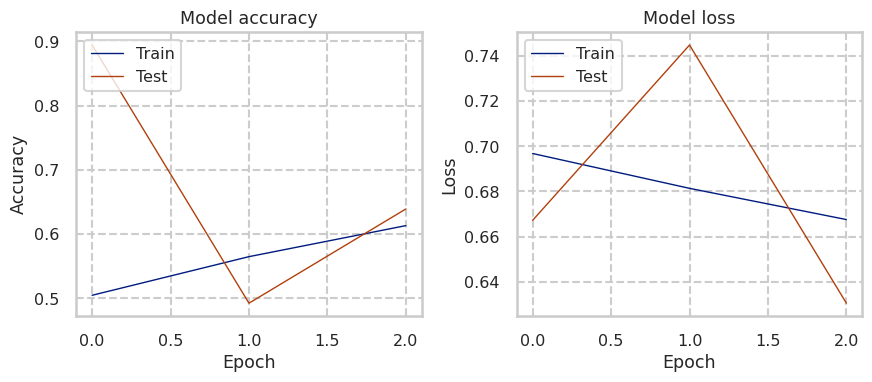

In [21]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()

In [22]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


# Recurrent Neural Network
## DistilBERT

In [17]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels = 2,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [18]:
pad_token=0
pad_token_segment_id=0
max_length=512

def convert_to_input(texts):
  input_ids, attention_masks, token_type_ids = [], [], []

  for text in tqdm(texts, position=0, leave=True):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, truncation=True, return_token_type_ids=True)

    i, t = inputs["input_ids"], inputs["token_type_ids"]
    m = [1] * len(i)

    padding_length = max_length - len(i)

    i = i + ([pad_token] * padding_length)
    m = m + ([0] * padding_length)
    t = t + ([pad_token_segment_id] * padding_length)

    input_ids.append(i)
    attention_masks.append(m)
    token_type_ids.append(t)

  return [np.asarray(input_ids),
            np.asarray(attention_masks),
            np.asarray(token_type_ids)]

X_train_input = convert_to_input(df_train['TEXT'])
X_test_input = convert_to_input(df_test['TEXT'])
X_val_input = convert_to_input(df_val['TEXT'])

100%|██████████| 6582/6582 [04:09<00:00, 26.37it/s]


In [22]:
def to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks},y

train_data = (X_train_input[0], X_train_input[1], X_train_input[2], df_train['READM_WITHIN_30'])
test_data = (X_test_input[0], X_test_input[1], X_test_input[2], df_test['READM_WITHIN_30'])
val_data = (X_val_input[0], X_val_input[1], X_val_input[2], df_val['READM_WITHIN_30'])

train_ds = tf.data.Dataset.from_tensor_slices(train_data).map(to_features).shuffle(len(df_train['READM_WITHIN_30'])).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices(test_data).map(to_features).batch(16)
val_ds = tf.data.Dataset.from_tensor_slices(val_data).map(to_features).batch(16)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3
254/254 [==============================] - 413s 1s/step - loss: 0.6967 - accuracy: 0.5035 - val_loss: 0.7198 - val_accuracy: 0.0779
Epoch 2/3
254/254 [==============================] - 387s 2s/step - loss: 0.6751 - accuracy: 0.5799 - val_loss: 0.6040 - val_accuracy: 0.7458
Epoch 3/3
254/254 [==============================] - 387s 2s/step - loss: 0.6234 - accuracy: 0.6647 - val_loss: 0.5900 - val_accuracy: 0.6603


In [24]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(test_ds, verbose=1)
y_pred_class = np.argmax(y_pred[0], axis=1)

print(classification_report(df_test['READM_WITHIN_30'], y_pred_class, digits=3))
print(roc_auc_score(df_test['READM_WITHIN_30'], y_pred_class))

412/412 [==============================] - 134s 322ms/step
              precision    recall  f1-score   support

           0      0.956     0.665     0.784      6124
           1      0.116     0.590     0.194       458

    accuracy                          0.660      6582
   macro avg      0.536     0.627     0.489      6582
weighted avg      0.897     0.660     0.743      6582

0.6271406221923053


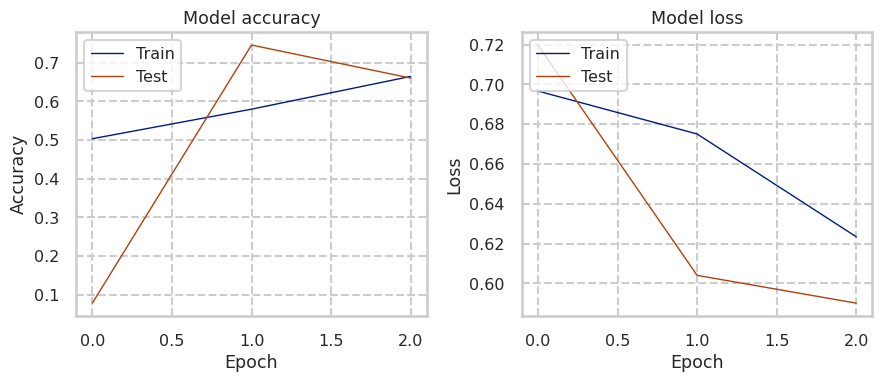

In [25]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()

In [26]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_57 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
